In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# pip install causalml pylift catboost duecredit

In [3]:
import numpy as np
import pandas as pd
import dask.dataframe as dd
import datetime

import causalml
import causalml.metrics as cmetrics
import causalml.inference.tree as ctree
import causalml.inference.meta.xlearner as xlearner
import causalml.inference.meta.rlearner as rlearner
import causalml.inference.meta.tlearner as tlearner

import pylift
import catboost as cb
import lightgbm as lgb

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

In [4]:
price = 80
cost_price = 52
communication = 1
discount = 40

In [5]:
receipts = dd.read_parquet('/content/drive/MyDrive/ml/receipts.parquet')

In [6]:
receipts = receipts.compute()

In [7]:
receipts = receipts.reset_index(drop=True)

In [8]:
receipts.head()

,customer_id,date,purchase_amt,discount,purchase_sum
0,26,0,12.125273,0,970.021866
1,53,0,34.357035,0,2748.562788
2,56,0,8.695825,0,695.666022
3,58,0,28.299046,0,2263.923641
4,64,0,32.547511,0,2603.800857


In [9]:
receipts[receipts['discount'] > 0]

,customer_id,date,purchase_amt,discount,purchase_sum
12936924,12,102,14.351911,40,1148.152907
12936925,19,102,3.840616,40,307.249242
12936926,39,102,12.696186,40,1015.694904
12936927,72,102,24.732437,40,1978.594946
12936928,86,102,16.100635,40,1288.050801
...,...,...,...,...,...
13755157,499846,108,19.380944,40,1550.475485
13755158,499893,108,22.097805,40,1767.824435
13755159,499906,108,20.053657,40,1604.292559
13755161,499929,108,10.735916,40,858.873243


In [10]:
receipts['date'].max()

249

In [11]:
len(receipts)

31741769

In [12]:
customers_list = receipts['customer_id'].unique()

In [13]:
len(customers_list)

1998286

In [14]:
customers = pd.read_csv('/content/drive/MyDrive/ml/customers.csv')

In [15]:
customers = customers.drop(columns=['Unnamed: 0'])

In [16]:
len(customers)

2000000

In [17]:
customers.head()

,customer_id,age,location
0,0,56,Oxenfurt
1,1,53,Hindarsfjall
2,2,41,Hindarsfjall
3,3,60,Kaer_Trolde
4,4,22,Spikeroog


In [18]:
len(customers['customer_id'].unique())

2000000

In [19]:
min(customers['age'].tolist()), max(customers['age'].tolist())

(20, 69)

In [20]:
campaigns = pd.read_csv('/content/drive/MyDrive/ml/campaigns.csv').drop(columns=['Unnamed: 0'])

In [21]:
campaigns.head()

,customer_id,n_offer_days,date,target_group_flag
0,0,7,102,1
1,1,7,102,1
2,2,7,102,1
3,3,7,102,1
4,4,7,102,1


In [22]:
len(campaigns)

500000

In [23]:
len(campaigns[campaigns['target_group_flag'] == 1])

500000

In [24]:
customer_ids_target = campaigns['customer_id'].tolist()

In [25]:
def get_features(
    receipts,
    date,
    days,
    id
):
    data = receipts[receipts['customer_id'] == id]
    data = data[
        (data['date'] >= (date - days)) & (data['date'] < (date))
        ]
    
    qnt = len(data)
    if qnt == 0:
        return 0, 0, 0

    avg = np.mean(data['purchase_sum'].tolist())

    if qnt == 1:
        interval = 0
    else:
        dates = data['date'].tolist()
        dates.sort(reverse=True)
        intervals = []
        for i in range(len(dates) - 1):
            intervals.append(dates[i] - dates[i + 1])
        interval = np.mean(intervals)
    return qnt, avg, interval

In [27]:
# X_train
N = int(1e3)

df = customers.sample(N).copy()

ids = df['customer_id'].tolist()

date = 102
days_list = [10, 20, 30, 60, 90]
for days in days_list:
    ans = [get_features(receipts, date, days, id) for id in ids]
    qnt, avg, interval = zip(*ans)

    df['qnt_' + str(days)] = qnt
    df['avg_' + str(days)] = avg
    df['int_' + str(days)] = interval

In [28]:
# treatment
treatment = []
for id in ids:
    if id in campaigns['customer_id'].tolist():
        treatment.append(1)
    else:
        treatment.append(0)

df['treatment'] = treatment

In [29]:
# target
date = 102
days = 30

target = []
for id in ids:
    data = receipts[receipts['customer_id'] == id]
    data = data[
        (data['date'] >= date) & (data['date'] < (date + days))
        ]
    purchase_sum = sum(data['purchase_sum'].tolist())
    if id in customer_ids_target:
        purchase_sum = purchase_sum - communication
    if purchase_sum + communication > price:
        purchase_sum = purchase_sum - sum(data['discount'].tolist())
    purchase_sum = purchase_sum - (sum(data['purchase_amt'].tolist()) * cost_price)
    target.append(purchase_sum)

df['target'] = target

In [30]:
col_target = 'target'
col_treatment = 'treatment'
cols_features = [
    'age',
    'location',
    'qnt_10',
    'avg_10',
    'int_10',
    'qnt_20',
    'avg_20',
    'int_20',
    'qnt_30',
    'avg_30',
    'int_30',
    'qnt_60',
    'avg_60',
    'int_60',
    'qnt_90',
    'avg_90',
    'int_90'
]

In [31]:
# convert categorical data: [age, location]
def get_age_cat(ages):
    ages_cat = []
    for age in ages:
        if age < 20:
            ages_cat.append(0)
        elif age >= 20 and age < 30:
            ages_cat.append(1)
        elif age >= 30 and age < 40:
            ages_cat.append(2)
        elif age >= 40 and age < 50:
            ages_cat.append(3)
        elif age >= 50 and age < 60:
            ages_cat.append(4)
        elif age >= 60 and age < 70:
            ages_cat.append(5)
        else:
            ages_cat.append(6)
    return ages_cat

In [32]:
locations_dict = {
    'Oxenfurt': 0,
    'Hindarsfjall': 1,
    'Kaer_Trolde': 2,
    'Spikeroog': 3,
    'Novigrad': 4,
    'Beauclair' :5,
    'Crows_perch': 6
    }

def get_loc_cat(locations):
    locations_cat = []
    for location in locations:
        locations_cat.append(locations_dict[location])
    return locations_cat

In [33]:
df['age'] = get_age_cat(df['age'].tolist())

In [34]:
df['location'] = get_loc_cat(df['location'].tolist())

In [35]:
df['age'] = df['age'].astype('category')
df['location'] = df['location'].astype('category')

In [36]:
fit_index, val_index = train_test_split(df.index, test_size=0.5, random_state=165)

In [37]:
_p_score_const = df.loc[fit_index,'treatment'].value_counts(normalize=True).loc[1]

In [38]:
_p_scores = pd.Series(data=_p_score_const, index=fit_index)

In [39]:
# model
model_n1 = rlearner.BaseRRegressor(
    learner=lgb.LGBMRegressor(),
    control_name=0,
    n_fold=4,
    random_state=165
)

In [40]:
model_n1.fit(
    X=df.loc[fit_index, cols_features].values,
    treatment=df.loc[fit_index, col_treatment].values,
    y=df.loc[fit_index, col_target].values,
    p=_p_scores
)

In [41]:
len(df.loc[fit_index, cols_features])

500

In [42]:
_eval_data = df.loc[val_index, cols_features + [col_treatment, col_target]]
_eval_data['score'] = model_n1.predict(_eval_data[cols_features])
_eval_data = _eval_data[['score', col_treatment, col_target]]

In [43]:
_eval_data['score'].describe()

count     500.000000
mean      -71.670606
std       587.603423
min     -2741.331464
25%      -419.247816
50%       -69.076779
75%       276.380617
max      1633.563277
Name: score, dtype: float64

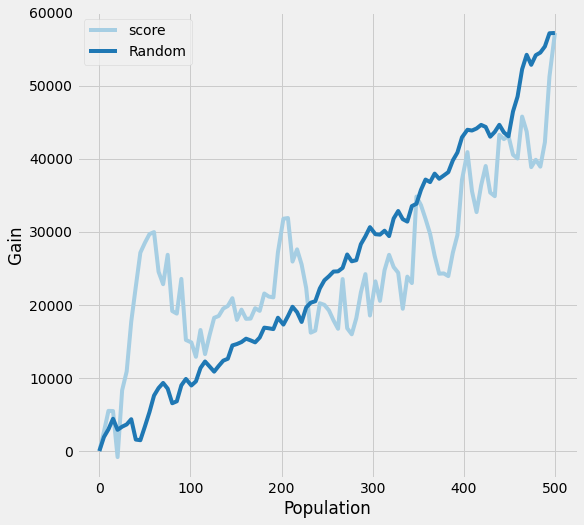

In [44]:
cmetrics.plot_gain(
    _eval_data,
    treatment_col=col_treatment,
    outcome_col=col_target,
)

In [45]:
threshold = np.percentile(_eval_data['score'], 85)